# Apply the trained embedding model to selected locations

The real purpose of this notebook is to develop and end-to-end process
to pull geo data, get MPP encodings, and then apply the initial and
final embedding models.

## Processing Setup

In [48]:
# Google colab
import os
from google.colab import drive
drive.mount('/content/drive')
project_home = '/content/drive/MyDrive/Projects/verge'
os.chdir(project_home)
!pip install geo_encodings osmnx

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Local processing setup
# project_home = '..'

## Notebook Setup

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from typing import List, Tuple, Optional

import pickle
import json
import copy
import pandas as pd
import numpy as np
import pyproj
import shapely
import osmnx
import geopandas

import sys
sys.path.append('%s/03-embeddings' % project_home)
from embedderv5 import *

sys.path.append(project_home)
from utils.verge import rules


## Parameters

In [51]:
# The name of the ROI to use.
roi_name = 'newengland'

# The name of the general-purpose data directory.
data_home = '%s/data' % (project_home)

# The name of the ROI-specific data directory.
roi_home = '%s/data/%s' % (project_home, roi_name)

# The unique identifier of the model to be used.
transformer_run_id = '301b'
collector_run_id = '301b'

## Preliminaries

In [52]:
# Read the ROI definition.
fname = '%s/roi.json' % roi_home
with open(fname) as source:
    roi = json.load(source)

tile_size = roi['tile_size']
encoding_resolution = roi['encoding_resolution']

roi

{'name': 'newengland',
 'lon0': -73.564321,
 'lat0': 41.253746,
 'lon1': -68.058533,
 'lat1': 45.116468,
 'proj_def': '\n+proj=tmerc +lat_0=43.185107 +lon_0=-70.81142700000001\n+k=1.0 +x_0=231000.0 +y_0=211000.0 +datum=WGS84 +units=m +no_defs\n',
 'tile_size': 2000,
 'tile_shift': 1000,
 'encoding_resolution': 100}

In [53]:
# Read the file containing labels.
fname = '%s/labels.csv' % data_home
labels = pd.read_csv(fname)

# Make a lookup tbale to get a numberical label from a text label.
label_lookup = {
    z['label']: z['id']
    for z in labels.to_dict('records')
}
label_count = len(label_lookup)
label_lookup

{'amenity : commercial': 0,
 'amenity : food and drink': 1,
 'amenity : parking lot': 2,
 'amenity : recreation': 3,
 'landuse : agricultural': 4,
 'landuse : commercial': 5,
 'landuse : forest': 6,
 'landuse : industrial': 7,
 'landuse : meadow': 8,
 'landuse : recreation': 9,
 'landuse : residential': 10,
 'landuse : retail': 11,
 'railway : rail': 12,
 'railway : rail stop': 13,
 'route : highway': 14,
 'route : primary road': 15,
 'route : residential road': 16,
 'route : secondary road': 17,
 'route : tertiary road': 18,
 'waterway : lakes and ponds': 19,
 'waterway : land': 20,
 'waterway : rivers and streams': 21}

In [54]:
# Define a local map projection, using the definition from the ROI file.
def get_projections(proj_def):
    ltm_crs = pyproj.CRS.from_proj4(proj_def)
    wgs84_crs = pyproj.CRS.from_epsg(4326)
    proj_forward = pyproj.Transformer.from_crs(wgs84_crs, ltm_crs, always_xy=True).transform
    proj_inverse = pyproj.Transformer.from_crs(ltm_crs, wgs84_crs, always_xy=True).transform
    return proj_forward, proj_inverse

proj_forward, proj_inverse = get_projections(roi['proj_def'])

In [55]:
# Read the coastline file.
fname = '%s/coastlines' % (roi_home)
coastlines_gdf = geopandas.read_file(fname)
print('%d coastline polygons' % len(coastlines_gdf))

def get_land_water(bounds, features):

    # Create a baseline polygon consisting of the whole AOI.
    landwater = copy.deepcopy(bounds)

    # Intersect that with the coastlines data.
    coastlines = shapely.union_all(coastlines_gdf['geometry'].values)
    landwater = landwater.intersection(coastlines)

    # subtract out any polygonal water feature.
    for _, f in features.iterrows():
        if f['geometry'].geom_type in ['Polygon', 'MultiPolygon']:
            if f['natural'] == 'water':
                landwater = shapely.difference(landwater, f['geometry'])

    return landwater

3514 coastline polygons


## Processing


### Set a tile center location

In [56]:
center_lat, center_lon = 43.000659, -70.921196 # Stratham Subaru

### Pull OSM data for the area around this location

In [57]:
# Get bounds for which to query OSM features.
buffer = roi['tile_size'] / 2 + 200
center_x, center_y = proj_forward(center_lon, center_lat)
x0, y0 = center_x - buffer, center_y - buffer
x1, y1 = center_x + buffer, center_y + buffer
lon0, lat0 = proj_inverse(x0, y0)
lon1, lat1 = proj_inverse(x1, y1)
query_bounds = [lon0, lat0, lon1, lat1]
print(query_bounds)


[-70.93589085254257, 42.989842170382644, -70.90649599145738, 43.011473927536166]


In [58]:
# Query for all relevant geospatial entities we need within the bounding box.
import osmnx
tags = {
    'landuse': True,
    'place': True,
    'highway': True,
    'railway': True,
    #'aeroway': True,
    'bridge': True,
    'tunnel': True,
    #'power': True,
    'natural': True,
    'waterway': True,
    'landcover': True,
    #'building': True,
    'amenity': True,
    'shop': True,
    'leisure': True
}
features = osmnx.features.features_from_bbox(query_bounds, tags=tags).reset_index()
print('%d features from OSM' % len(features))


1823 features from OSM


In [59]:
# Just retain the relevant columns.
columns_in_rules = set(['geometry', 'amenity', 'highway', 'landuse', 'railway', 'water', 'waterway', 'natural'])
columns_in_features = set(features.columns)
columns_to_keep = list(columns_in_rules.intersection(columns_in_features))
features = features[columns_to_keep]
features.head(3)

,landuse,natural,waterway,geometry,amenity,water,highway
0,NaN,NaN,NaN,POINT (-70.92247 42.99919),NaN,NaN,traffic_signals
1,NaN,NaN,NaN,POINT (-70.93157 42.99691),NaN,NaN,motorway_junction
2,NaN,NaN,NaN,POINT (-70.92713 42.99249),NaN,NaN,traffic_signals


### Re-organize geo info for this tile

In [60]:
# Down-select and re-format any relevant geospatial entities ("gents").
gents = []
for feature in features.to_dict('records'):

    geomxy = shapely.ops.transform(proj_forward, feature['geometry'])
    if geomxy.is_empty:
        continue
    gtype = geomxy.geom_type

    for rule in rules:
        if gtype == rule['gtype']:
            osm_key = rule['osm_key']
            if osm_key in feature:
                osm_value = str(feature[osm_key])
                if osm_value in rule['osm_values']:
                    gents.append({
                        'feature': feature,
                        'category': rule['gent_category'],
                        'label': rule['gent_label'],
                        'geomxy': geomxy,
                        'gtype': gtype
                    })
print('%d features selected' % len(gents))


300 features selected


In [61]:
# Create a "land/water" polygon.
lons = [lon0, lon1, lon1, lon0, lon0]
lats = [lat0, lat0, lat1, lat1, lat0]
lonlat_bounds = shapely.Polygon(list(zip(lons, lats)))
landwater = get_land_water(lonlat_bounds, features)
landwaterxy = shapely.ops.transform(proj_forward, landwater)
gents.append({
    'category': 'waterway',
    'label': 'land',
    'geomxy': landwaterxy,
    'gtype': landwaterxy.geom_type
})


In [62]:
# Get the bounds for this tile in projected coordinates.
buffer = roi['tile_size'] / 2
center_x, center_y = proj_forward(center_lon, center_lat)
x0, y0 = center_x - buffer, center_y - buffer
x1, y1 = center_x + buffer, center_y + buffer
xx = [x0, x1, x1, x0, x0]
yy = [y0, y0, y1, y1, y0]
tile_bbox = shapely.Polygon(list(zip(xx, yy)))

In [63]:
# Re-project all geospatial entities and clip them to the bounds of this tile.
tile_gents = []
for gent in gents:
    geomxy = shapely.affinity.translate(
        gent['geomxy'].intersection(tile_bbox),
        xoff=-x0, yoff=-y0
    )
    if geomxy.is_empty:
        continue
    tile_gents.append({
        'category': gent['category'],
        'label': gent['label'],
        'geometry': geomxy,
        'gtype': gent['gtype'],
        'xoff': x0,
        'yoff': y0,
    })
print('%d geospatial entities' % len(tile_gents))
pd.DataFrame(tile_gents).head(3)

219 geospatial entities


,category,label,geometry,gtype,xoff,yoff
0,amenity,commercial,POINT (418.4354396635317 1.3595715957635548),Point,221049.424774,189514.680608
1,amenity,commercial,POINT (1194.7591855522187 1242.6530638959666),Point,221049.424774,189514.680608
2,amenity,commercial,POINT (671.1252223148767 236.52948677458335),Point,221049.424774,189514.680608


### Apply MPP encoding to all entities in this tile

In [64]:
# Define an encoder to use.
from geo_encodings import MPPEncoder
encoder = MPPEncoder(
    region=[0, 0, tile_size, tile_size],
    resolution=encoding_resolution,
    center=True
)
geo_encoding_dim = len(encoder)
print('%d elements in encodings' % geo_encoding_dim)


400 elements in encodings


In [65]:
# Apply encodings.
for gent in tile_gents:
    gent['encoding'] = encoder.encode(gent['geometry']).values()


### Get one-hot label vectors for each entity

In [66]:
# We will also need the one-hot label vectors for each entity.
for gent in tile_gents:
    label_name = '%s : %s' % (gent['category'], gent['label'])
    label_id = label_lookup[label_name]
    label_onehot = np.full(label_count, 0, dtype=float)
    label_onehot[label_id] = 1
    gent['onehot'] = label_onehot



In [67]:
# Display that encoding as a heat map.
mpps = np.vstack([z['encoding'] for z in tile_gents])
print(mpps.shape)
onehots = np.vstack([z['onehot'] for z in tile_gents])
print(onehots.shape)

tile_encoding = np.hstack([onehots, mpps])
print(tile_encoding.shape)

(219, 400)
(219, 22)
(219, 422)


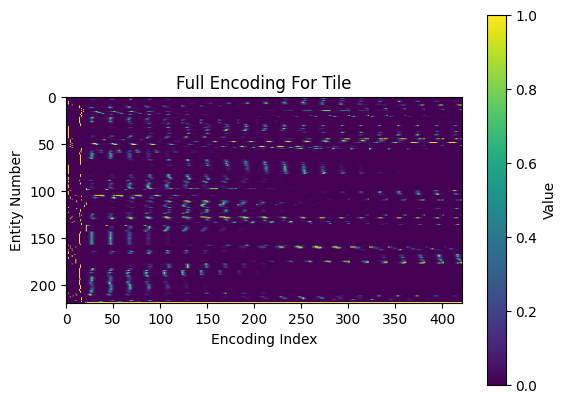

In [68]:
import numpy as np
import matplotlib.pyplot as plt

data = tile_encoding

plt.imshow(data, cmap='viridis', aspect='equal')  # 'viridis' is a good default colormap
plt.colorbar(label="Value")  # add a color scale bar
plt.title("Full Encoding For Tile")
plt.xlabel("Encoding Index")
plt.ylabel("Entity Number")
plt.show()


### Initial embedding for this tile

In [69]:
from utils.geo_transformer_mem import VergeDataset, verge_collate_fn, GeospatialTransformer

# Get initial embedding for this tile.
transformer = GeospatialTransformer(
    feature_dim = geo_encoding_dim + label_count,
    model_dim=128,
    num_heads=4,
    num_layers=4,
    num_classes=label_count,
    dropout=0.2
)

model_fname = '%s/models/transformer-%s' % (roi_home, transformer_run_id)
transformer = torch.load(model_fname, weights_only=False, map_location=torch.device('cpu'))
print('loaded %s' % model_fname)

n_param = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print('%d trainable parameters in model' % n_param)


loaded /content/drive/MyDrive/Projects/verge/data/newengland/models/transformer-301b
850070 trainable parameters in model


In [70]:
input_features = torch.tensor(tile_encoding, dtype=torch.float32).unsqueeze(0)
print(input_features.shape)

attention_mask = torch.ones(1, tile_encoding.shape[0])

input_attention_mask = torch.ones(1, tile_encoding.shape[0], dtype=torch.float32)
print(input_attention_mask.shape)


torch.Size([1, 219, 422])
torch.Size([1, 219])


In [73]:
transformed = transformer.embed(input_features, input_attention_mask)
print(transformed.shape)

torch.Size([1, 219, 128])


### Get the final embedding for this tile

In [74]:
import sys
sys.path.append('%s/03-embeddings' % project_home)
from embedderv5 import ContrastivePairDataset, PermutationInvariantModel, TripletContrastiveLoss, triplet_collate_fn

In [77]:
# Initialize model
embedding_dim = 128
model = PermutationInvariantModel(
    input_dim=embedding_dim,
    hidden_dim=128,
    embedding_dim=embedding_dim,
    num_attention_heads=8,
    num_linear_layers=3,
    dropout=0.1
)

model_fname = '%s/models/collector-%s.pth' % (roi_home, collector_run_id)
state_dict = torch.load(model_fname, map_location='cpu')
model.load_state_dict(state_dict)
print('loaded %s' % model_fname)

n_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('%d trainable parameters in model' % n_param)


loaded /content/drive/MyDrive/Projects/verge/data/newengland/models/collector-301b.pth
181768 trainable parameters in model


In [79]:
transformed.shape

torch.Size([1, 219, 128])

In [87]:
masks = torch.ones(1, tile_encoding.shape[0], dtype=torch.bool)
print(masks.shape)

torch.Size([1, 219])


In [88]:

emb = model(transformed, masks)


In [89]:
emb.shape

torch.Size([1, 128])

In [90]:
emb

tensor([[ 9.4822e-02, -6.5482e-02,  1.4129e-01,  3.7440e-02,  1.6431e-02,
         -2.8715e-02, -1.5391e-01, -1.7755e-02, -9.2423e-03,  5.7261e-02,
          4.1987e-02, -1.7329e-02, -2.0996e-02, -3.4701e-02, -1.1677e-01,
         -1.6695e-02, -1.1099e-01, -1.6132e-02, -1.4991e-02, -9.2602e-02,
         -5.5923e-02, -1.0274e-01,  8.6417e-03,  2.8630e-02, -4.5956e-02,
         -7.6988e-02,  9.3412e-02, -8.0672e-02,  1.0590e-02, -5.1874e-02,
          1.6201e-01, -1.0483e-01,  7.3805e-02, -2.0973e-02,  1.9918e-01,
          2.1252e-01,  9.9553e-03,  1.9240e-01, -3.4845e-02,  1.0048e-01,
         -3.0684e-02,  8.0337e-02,  8.3566e-02, -1.5760e-03, -4.9988e-02,
          7.5671e-02, -2.8856e-02,  3.0971e-02,  1.4844e-01, -3.0941e-02,
         -1.7902e-01, -8.6773e-03, -9.0415e-02,  9.0740e-02, -9.1488e-02,
         -6.7421e-02,  9.2710e-03,  2.2101e-02, -3.6990e-03,  2.2197e-01,
          9.9009e-03, -1.3031e-01, -3.7527e-02, -3.9407e-02,  1.0321e-01,
         -7.3204e-02, -2.1341e-02, -1.